In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/ethusd-cryptocurrency/Binance_ETHUSDT_d - Binance_ETHUSDT_d.csv


## Loading Data

In [2]:
df=pd.read_csv('../input/ethusd-cryptocurrency/Binance_ETHUSDT_d - Binance_ETHUSDT_d.csv')

In [3]:
df.head()

,date,open,high,low,close
0,2021-05-18 0:00:00,3282.25,3304.82,3240.00,3260.97
1,2021-05-17 0:00:00,3581.81,3587.06,3102.00,3282.51
2,2021-05-16 0:00:00,3646.24,3879.00,3343.06,3582.10
3,2021-05-15 0:00:00,4075.02,4134.05,3632.00,3646.68
4,2021-05-14 0:00:00,3717.92,4173.28,3691.35,4075.01


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1372 entries, 0 to 1371
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   date    1372 non-null   object 
 1   open    1372 non-null   float64
 2   high    1372 non-null   float64
 3   low     1372 non-null   float64
 4   close   1372 non-null   float64
dtypes: float64(4), object(1)
memory usage: 53.7+ KB


In [5]:
from datetime import date
import json
import requests
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, LSTM
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error
%matplotlib inline
sns.set_style('darkgrid')
import plotly.graph_objects as go

## Visualisation of Ethereum Prices using its trading features

In [6]:
fig = go.Figure(data=go.Ohlc(x=df['date'],
                    open=df['open'],
                    high=df['high'],
                    low=df['low'],
                    close=df['close']))
fig.show()

In [7]:
import plotly.express as px
fig = px.line(df, x='date', y='close')
fig.show()

## Min-Max Scaling data 

In [8]:
close_data=df.reset_index()['close']

In [9]:
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler()
scaled_data=scaler.fit_transform(np.array(close_data).reshape(-1,1))

## Train/Test Splitting Data

In [10]:
train_size=int(len(scaled_data)*0.7)
test_size=len(scaled_data)-train_size
train_data,test_data=scaled_data[0:train_size,:],scaled_data[train_size:len(scaled_data),:]

In [11]:
train_size,test_size

(960, 412)

In [12]:
def time_series_data(dataset,step):
    x,y=[],[]
    for i in range(len(dataset)-step-1):
        # creating a series of values
        series=dataset[i:(i+step),0]
        # appending that series to x
        x.append(series)
        # appending the next values of series x after step to y
        y.append(dataset[i+step,0])
    return np.array(x),np.array(y)

In [13]:
step=9
x_train,y_train=time_series_data(train_data,step)
x_test,y_test=time_series_data(test_data,step)

In [14]:
x_train.shape,y_train.shape

((950, 9), (950,))

In [15]:
x_train =x_train.reshape(x_train.shape[0],x_train.shape[1] , 1)
x_test = x_test.reshape(x_test.shape[0],x_test.shape[1] , 1)

## Model Building

In [16]:
model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(49,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1,activation='sigmoid'))
model.compile(loss='mean_squared_error',optimizer='adam')

In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 49, 50)            10400     
_________________________________________________________________
lstm_1 (LSTM)                (None, 49, 50)            20200     
_________________________________________________________________
lstm_2 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [18]:
history=model.fit(x_train,y_train,validation_data=(x_test,y_test),epochs=50,batch_size=64)

Epoch 1/50
15/15 [==============================] - 7s 142ms/step - loss: 0.1712 - val_loss: 0.0394
Epoch 2/50
15/15 [==============================] - 0s 27ms/step - loss: 0.0477 - val_loss: 0.0141
Epoch 3/50
15/15 [==============================] - 0s 28ms/step - loss: 0.0286 - val_loss: 0.0136
Epoch 4/50
15/15 [==============================] - 0s 27ms/step - loss: 0.0296 - val_loss: 0.0080
Epoch 5/50
15/15 [==============================] - 0s 29ms/step - loss: 0.0244 - val_loss: 0.0036
Epoch 6/50
15/15 [==============================] - 0s 26ms/step - loss: 0.0202 - val_loss: 0.0033
Epoch 7/50
15/15 [==============================] - 0s 27ms/step - loss: 0.0164 - val_loss: 0.0017
Epoch 8/50
15/15 [==============================] - 0s 27ms/step - loss: 0.0082 - val_loss: 9.8282e-04
Epoch 9/50
15/15 [==============================] - 0s 27ms/step - loss: 0.0020 - val_loss: 0.0044
Epoch 10/50
15/15 [==============================] - 0s 28ms/step - loss: 0.0016 - val_loss: 0.0024
Epoc

## Plotting losses

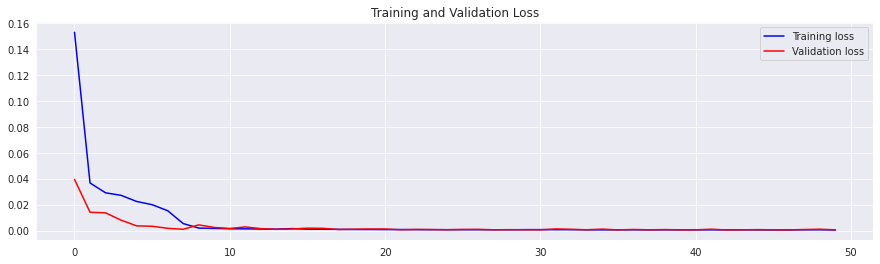

In [19]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(loss))
plt.figure(figsize=(15,4))
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title("Training and Validation Loss")
plt.legend()
plt.show()

## Making Predictions

In [20]:
train_predict=model.predict(x_train)
test_predict=model.predict(x_test)

In [21]:
# doing inverse transform to scale it back to original scale
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)

In [22]:
y_test=scaler.inverse_transform(y_test.reshape(y_test.shape[0],1))

## Evaluation

In [23]:
from sklearn.metrics import mean_squared_error
np.sqrt(mean_squared_error(y_test,test_predict))

95.00968599330879

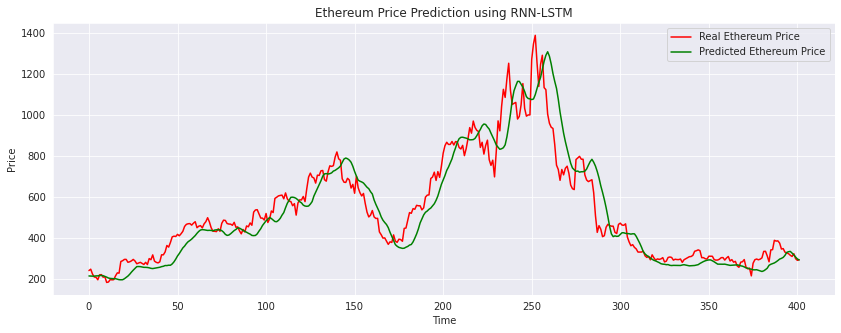

In [24]:
plt.figure(figsize=(14,5))
plt.plot(y_test, color = 'red', label = 'Real Ethereum Price')
plt.plot(test_predict, color = 'green', label = 'Predicted Ethereum Price')
plt.title('Ethereum Price Prediction using RNN-LSTM')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

### Foreacsting for next 30 days